In [55]:
import pandas as pd
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

In [8]:
def generate_timeseries(
    seed=23,
    start_timestamp=datetime.datetime(2022, 1, 1, 0, 0, 0),
    end_timestamp=datetime.datetime(2023, 1, 1, 0, 0, 0),
    timestamp_sec_step=10,
    row_remove_percentage=0.75,
    quality_percentage=0.75,
    value_mean=13.56,
    value_std_dev=3.7
):
    random.seed(seed)
    np.random.seed(seed)
    
    timestamp_list = pd.date_range(start=start_timestamp, end=end_timestamp, freq=f"{timestamp_sec_step}s")
    remove_count = int(len(timestamp_list) * row_remove_percentage)
    timestamp_list = np.random.choice(timestamp_list, size=len(timestamp_list) - remove_count, replace=False)
    
    df = pd.DataFrame({'t': timestamp_list})
    df['v'] = np.random.normal(value_mean, value_std_dev, len(df))
    df['q'] = np.random.choice([1, 0], size=len(df), p=[quality_percentage, 1 - quality_percentage])
    
    return df.sort_values('t').reset_index(drop=True)


In [9]:
def plot_2_series(A,B):
    fig, ax1 = plt.subplots()
    ax1.plot(A['t'], A['v'], label='Series A', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Series A', color='blue')
    ax1.tick_params('y', colors='blue')
    
    ax2 = ax1.twinx()
    
    ax2.plot(B['t'], B['v'], label='Series B', color='red')
    ax2.set_ylabel('Series B', color='red')
    ax2.tick_params('y', colors='red')
    
    plt.title('Time Series Comparison')
    
    plt.show()

In [10]:
def calculate_time_weighted_average(df):
    df['t'] = pd.to_datetime(df['t'])  # Convert 't' column to datetime if needed
    df['d'] = pd.to_timedelta(df['d'])  # Convert 'd' column to timedelta if needed
    df['w'] = df['d'] / df['d'].sum()  # Calculate the weights based on duration
    df['w'].fillna(0, inplace=True)  # Fill missing weights with 0
    time_weighted_avg = np.average(df['v'], weights=df['w'])  # Calculate the time-weighted average
    return time_weighted_avg


In [65]:
A = generate_timeseries(timestamp_sec_step=10,value_mean=5000,value_std_dev=1000,quality_percentage=0.9,seed=13)
B = generate_timeseries(timestamp_sec_step=10,value_mean=200,value_std_dev=25,quality_percentage=0.9,seed=22)

In [66]:
A['d'] = A['t'].diff().dt.total_seconds()
B['d'] = B['t'].diff().dt.total_seconds()

In [72]:
A_daily_time_weighted_avg = A.groupby(pd.Grouper(key="t", freq="86400000ms")).apply(calculate_time_weighted_average).reset_index(name='v')
print(A_daily_time_weighted_avg)


             t            v
0   2022-01-01  5015.526058
1   2022-01-02  5011.719772
2   2022-01-03  5070.401368
3   2022-01-04  5046.962924
4   2022-01-05  4998.782945
..         ...          ...
360 2022-12-27  5026.658940
361 2022-12-28  5041.311008
362 2022-12-29  4965.356980
363 2022-12-30  5015.606416
364 2022-12-31  5000.785253

[365 rows x 2 columns]


In [75]:
A.set_index('t', inplace=True)
A_mean = A.resample('D').mean().reset_index()
A = A.reset_index()
A_daily_time_weighted_avg = A_daily_time_weighted_avg.reset_index()

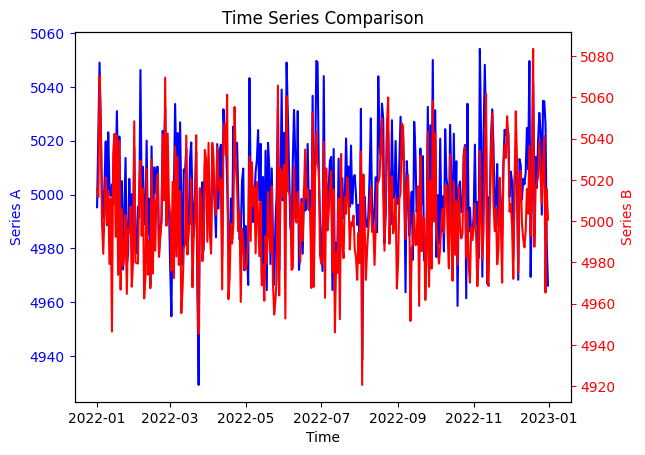

In [76]:
plot_2_series(A_mean,A_daily_time_weighted_avg)